In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns
import os
import json
from sklearn.decomposition import PCA
#import umap.umap_ as umap
from itertools import permutations
np.random.seed(42)

%matplotlib inline  
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 80, 'linewidths':0}

In [2]:
# Set data input folder
# Download files described in README.md to this folder
input_folder = "inputs"

# Set output folder, subfolder
output_folder = "outputs"
if not os.path.exists(output_folder):
    os.makedirs(output_folder, exist_ok=True)
if not os.path.exists(os.path.join(output_folder,"figure_panels")):
    os.makedirs(os.path.join(output_folder,"figure_panels"), exist_ok=True)

In [3]:
# Load p_values from the hit calling process
df_p_value = pd.read_csv('outputs/HeLa_CP_significant_features_mann_whitney_p_values_cp_features.csv.gz')
df_p_value = df_p_value.set_index('Gene')

# Load expression data 
with open("outputs/HeLa_CP_CCLE_expression_summary.json") as f:
    express = json.load(f)
    zero_tpm_list = express['zero_tpm']
    expressed_gene_list = express['expressed_genes']



In [4]:
# Extract the features from the guide level profiles
feature_dict = {}
features = list(df_p_value.columns)[2:]
dapi_list = [feature for feature in df_p_value.columns if 'dapi'  in feature.lower()]
phalloidin_list = [feature for feature in df_p_value.columns if 'phalloidin'  in feature.lower()]
wga_list = [feature for feature in df_p_value.columns if 'wga'  in feature.lower()]
cona_list = [feature for feature in df_p_value.columns if 'cona' in feature.lower()]
mito_list = [feature for feature in df_p_value.columns if 'mito' in feature.lower()]

feature_dict = {'DAPI':dapi_list,'Phalloidin':phalloidin_list,'WGA':wga_list,'ConA':cona_list,
                'Mito':mito_list,'Sum':features}
print(f'Number of features per compartment: ','\n',
            'DAPI features: ',len(dapi_list),'\n',
            'Phalloidin features: ',len(phalloidin_list),'\n',      
            'WGA features: ',len(wga_list),'\n',
            'ConA features: ',len(cona_list),'\n',
            'Mito features: ',len(mito_list),'\n',
)

Number of features per compartment:  
 DAPI features:  223 
 Phalloidin features:  33 
 WGA features:  37 
 ConA features:  31 
 Mito features:  113 



In [5]:
# Calculate false discovery rate (FDR)
def FDR_1(control_sig_feature):
    total = len(control_sig_feature)
    FDR_1 = int(total/100)
    mito_1, cona_1, wga_1, dapi_1, phal_1, sum_1 = 0,0,0,0,0,0
    channels = ['Mito','ConA','WGA','DAPI','Phalloidin']
    c = 500
    feat_1 = 0
    while feat_1 <= FDR_1:
        feat_1 = len(control_sig_feature.query('Mito > @c'))
        mito_1 = c + 1
        c-=1    
    
    c = 500
    feat_1 = 0
    while feat_1 <= FDR_1:
        feat_1 = len(control_sig_feature.query('ConA > @c'))
        cona_1 = c + 1
        c-=1     
    
    c = 500
    feat_1 = 0
    while feat_1 <= FDR_1:
        feat_1 = len(control_sig_feature.query('WGA > @c'))
        wga_1 = c + 1
        c-=1    
        
    c = 500
    feat_1 = 0
    while feat_1 <= FDR_1:
        feat_1 = len(control_sig_feature.query('DAPI > @c'))
        dapi_1 = c + 1
        c-=1    
    
    c = 500
    feat_1 = 0
    while feat_1 <= FDR_1:
        feat_1 = len(control_sig_feature.query('Phalloidin > @c'))
        phal_1 = c + 1
        c-=1    
        
    c = 500
    feat_1 = 0
    while feat_1 <= FDR_1:
        feat_1 = len(control_sig_feature.query('Sum > @c'))
        sum_1 = c + 1
        c-=1
    
    return mito_1, cona_1, wga_1, dapi_1, phal_1, sum_1




In [6]:
# Quantification of number of significant features per compartment at a certain p-value
threshold_dict = {}
p_value = 0.001
gene_list = list(df_p_value.index)

df_sig_feature = pd.DataFrame(index=gene_list)
for gene in gene_list:
    for channel in feature_dict.keys():
        count = 0
        for feat in feature_dict[channel]:
            if df_p_value.loc[gene,feat]<p_value:
                count += 1
        df_sig_feature.loc[gene,channel] = count
    
df_sig_feature = df_sig_feature.drop(index = 'sig_gene_count')
# Perturbations divided into 2 groups of controls with 0 TPM and others
df_sig_feature_zero_tpm = df_sig_feature.loc[zero_tpm_list]
df_sig_feature_expressed = df_sig_feature.loc[expressed_gene_list]

# Compute and print the threshold for FDR calculations at 5% from the 0 TPM gene perturbations
mito_1, cona_1, wga_1, dapi_1, phal_1, sum_1 = FDR_1(df_sig_feature_zero_tpm)

threshold_dict = {'Mito':mito_1,'ConA':cona_1,'WGA':wga_1,'DAPI':dapi_1,'Phalloidin':phal_1,'Sum':sum_1}

print(f'For HeLa CP \n'
    'Mito genes', mito_1, '\n', 
    'ConA genes', cona_1, '\n', 
    'WGA genes', wga_1, '\n',
    'DAPI genes', dapi_1, '\n',
    'Phalloidin genes', phal_1, '\n',
    'Whole Profile genes', sum_1)
# Save the number of significant features per channel for whole cell hits and compartment hits

whole_cell_hits = df_sig_feature_expressed.query('Sum > @sum_1')                                                                                                                                                                                                   
comp_spec_hits = df_sig_feature_expressed.query('Sum <= @sum_1').query('Mito > @mito_1 | ConA > @cona_1 | WGA > @wga_1 | DAPI > @dapi_1 | Phalloidin > @phal_1')
whole_cell_hits.reset_index().rename(columns={'index':'Gene'}).to_csv(os.path.join(output_folder,f'HeLa_CP_plate_level_median_per_feat_sig_genes_1_FDR_whole_cell_hits.csv'),index=False)
comp_spec_hits.reset_index().rename(columns={'index':'Gene'}).to_csv(os.path.join(output_folder,f'HeLa_CP_plate_level_median_per_feat_sig_genes_1_FDR_compartment_specific_hits.csv'),index=False)


For HeLa CP 
Mito genes 3 
 ConA genes 3 
 WGA genes 1 
 DAPI genes 10 
 Phalloidin genes 3 
 Whole Profile genes 21


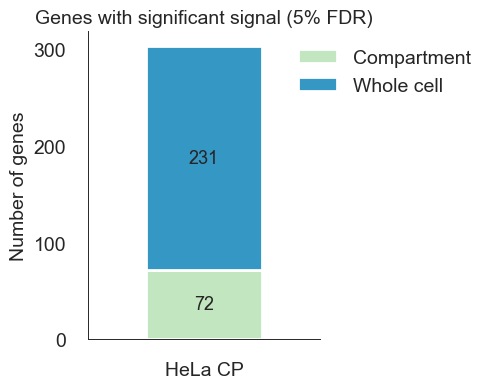

In [7]:
# Plot hits summary for Fig 3A
mpl.rc('axes', linewidth=0.7)
mpl.rc('xtick', labelsize=14)
mpl.rc('xtick', labelsize=14)

fig, ax = plt.subplots(figsize=(3,4))
colors = sns.color_palette('GnBu')[:8]
hits_plot = pd.DataFrame({'Compartment': [len(comp_spec_hits)],
                         'Whole cell': [len(whole_cell_hits)]},
                        index=['HeLa CP'])

hits_plot.plot(kind='bar', 
               stacked=True,
               color=[colors[1], colors[4]],
               legend = 'reverse',
               rot = 0,
               fontsize= 14,
               width = 0.5,
               ax=ax)

ax.set_title('Genes with significant signal (5% FDR)',size=14) #Genes with significant signal above noise
ax.set_ylabel('Number of genes',size=14)

ax.bar_label(ax.containers[0],label_type='center',size=13)
ax.bar_label(ax.containers[1],label_type='center',size=13)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.legend(loc="upper left", bbox_to_anchor=(0.83,1),frameon=False, ncol=1, fontsize =14)
fig.savefig(os.path.join(output_folder,'figure_panels','Fig3A_HeLa_DMEM_HPLM_whole_cell_compartment_specific_hits.png'),dpi = 300,bbox_inches='tight')

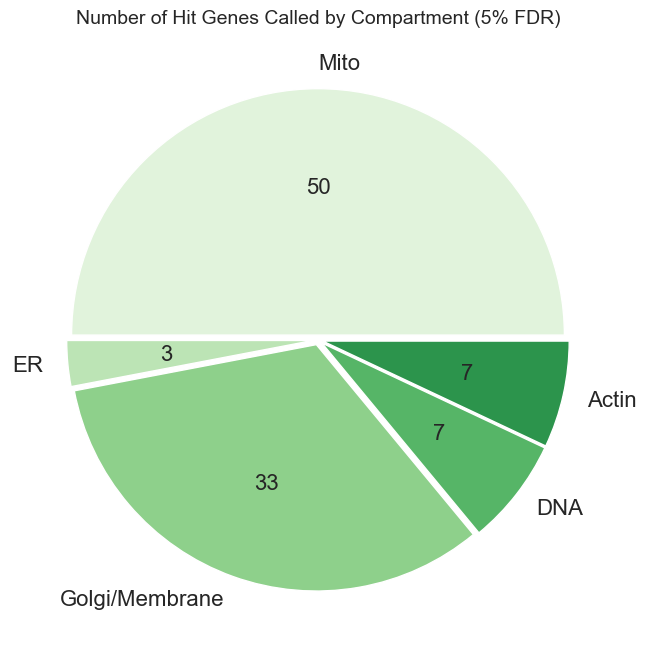

In [8]:
# Plot hits summary for Fig 3B
def absolute_value2(val):
    a  = data[np.abs(data - val/100.*sum(data)).argmin() ]
    return a

labels = ['Mito','ER','Golgi/Membrane','DNA','Actin']

data = [len(comp_spec_hits.query('Mito > @mito_1 & Sum <= @sum_1')),
        len(comp_spec_hits.query('ConA > @cona_1 & Sum <= @sum_1')),
        len(comp_spec_hits.query('WGA > @wga_1 & Sum <= @sum_1')),
        len(comp_spec_hits.query('DAPI > @dapi_1 & Sum <= @sum_1')),
        len(comp_spec_hits.query('Phalloidin > @phal_1 & Sum <= @sum_1')),
       ]
colors = sns.color_palette('Greens')[:8]    
fig, ax = plt.subplots(figsize=(12,8))
explode = [0.02]*len(data)
sns.set_theme(style='white',palette='RdBu')
plt.pie(data,
        labels=labels,
        autopct=absolute_value2,
        colors=colors,
        textprops={'fontsize': 16},
        explode=explode) #(0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05)
ax.set_title('Number of Hit Genes Called by Compartment (5% FDR)',size=14)
fig.savefig(os.path.join(output_folder,'figure_panels',f'HeLa_CP_compartment_hits_distribution_CP_features.png'),dpi = 300,bbox_inches='tight')
